## Project Scope ##

The goal of this master's project is to create a system that is part of some bigger medical system like a chatbot and it can read the input of potential patients in natural language, and then recognize the medical intent and symptoms. Since BERT is only an encoder model, we can't expect it to generate the extensive result. If there's a need to extend this chatbot we can use some open-source AI model like LLAMA-3 or Mistral AI.

First, let's load the libraries we need as well as load the data we'll use.

In [1]:
pip install torch torchvision torchaudio transformers pandas numpy matplotlib scikit-learn matplotlib jupyter



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Users/danicasimic/torch_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
print("PyTorch version:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
print("MPS built:", torch.backends.mps.is_built())

PyTorch version: 2.8.0
MPS available: True
MPS built: True


In [5]:
!python -m pip install --upgrade pip setuptools wheel
!python -m pip install seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s  0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 80.9.0
    Uninstalling setuptools-80.9.0:
      Successfully uninstalled setuptools-80.9.0━━━━━━ 0/4 [setuptools]
  Attempting uninstall: pip━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/4 [setuptools]
    Found existing installation: pip 25.2━━━━━━━━━ 0/4 [setuptools]
    Uninstalling pip-25.2:━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [pip]
      Successfully uninstalled pip-25.237m╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [pip]
  Attempting uninstall: packaging0m╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [pip]
    Found existing installation: packaging 23.2━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [pip]
    Uninstalling packaging-23.2:╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [pip]
      Successfully uninstalled packaging-23.20m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [pip]
  Attempting uninstall: wheel0m╺━━━━━━━━

In [6]:
!pip install transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
data = pd.read_csv('data.csv')
data1 = data[['phrase','prompt']]
data1.sample(5)

,phrase,prompt
6099,I feel lightheaded when I stand up,Feeling dizzy
6608,Yesterday I had a shouder pain,Shoulder pain
3592,I don't have problems taking in breath but out...,Hard to breath
6593,I fell through a window while I was cleaning i...,Open wound
1751,I don't have problems taking in breath but out...,Hard to breath


In [8]:
df=data1.copy()
df.isna().sum()

phrase    0
prompt    0
dtype: int64

In [10]:
df['prompt'].value_counts()

prompt
Acne                  328
Shoulder pain         320
Joint pain            318
Infected wound        306
Knee pain             305
Cough                 293
Feeling dizzy         283
Muscle pain           282
Heart hurts           273
Ear ache              270
Hair falling out      264
Head ache             263
Feeling cold          263
Skin issue            262
Stomach ache          261
Back pain             259
Neck pain             251
Internal pain         248
Blurry vision         246
Body feels weak       241
Hard to breath        233
Emotional pain        231
Injury from sports    230
Foot ache             223
Open wound            208
Name: count, dtype: int64

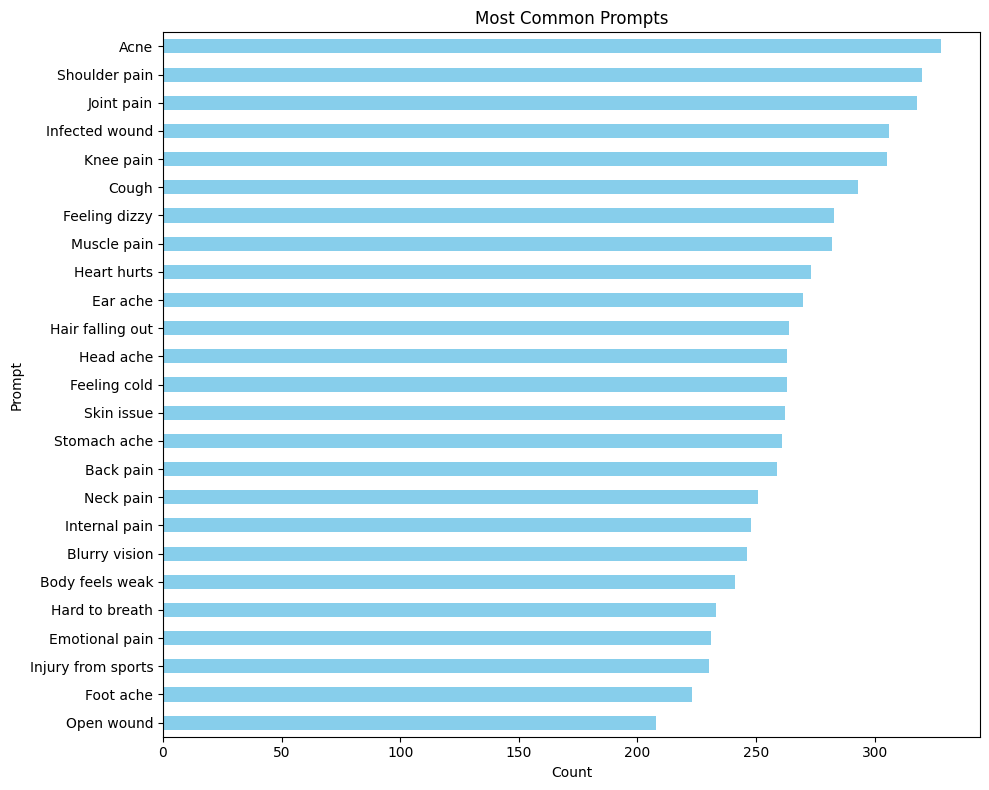

In [11]:
import matplotlib.pyplot as plt

top_counts = df['prompt'].value_counts().head(30)

plt.figure(figsize=(10, 8))
top_counts.sort_values().plot(kind='barh', color='skyblue')

plt.title('Most Common Prompts')
plt.xlabel('Count')
plt.ylabel('Prompt')
plt.tight_layout()
plt.show()

In [17]:
print('Total number of intents: %d' % len(df['prompt'].value_counts().index))
print('Total number of intents: %d' % len(df['prompt'].value_counts().index))


Total number of intents: 25
Total number of intents: 25


## 3. Split data to train, validation and test sets for balance

It's the best to split data to train(70%), validation(10%) and testset (20%) stratified by the variable "intent". After stratification, data for each intent will balanced and data for each set will be proportional to 70%, 10% and 20%. That is crucial for training and testing purposes.

In [20]:
from sklearn.model_selection import train_test_split

X, sentence_test, y, intent_test = train_test_split(df.phrase, df.prompt, stratify = df.prompt,test_size=0.2, random_state=4612)
sentence_train, sentence_val, intent_train, intent_val = train_test_split(X, y, stratify = y,test_size=0.125, random_state=4612)


In [22]:
print(f"#examples in training set:{ sentence_train.shape[0]}\n#examples in validation set:{ sentence_val.shape[0]}\n#examples in test set:{ sentence_test.shape[0]}")

#examples in training set:4662
#examples in validation set:666
#examples in test set:1333


## 4. Tokenization and input formatting

Let's prep the input data to the correct format before training as follows:

* tokenizing all sentences
* padding and truncating all sentences to the same length.
* Creating the attention masks which explicitly differentiate real tokens from [PAD] tokens. 0 or 1.
* encoding the label "intent" to numbers. 25 intents to 25 numbers.
* creating DataLoaders for our training, validation and test sets

In [25]:
pip install --upgrade "ipywidgets==8.*" "jupyterlab-widgets==3.*" "widgetsnbextension==4.*"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 14.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s  0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.14
    Uninstalling widgetsnbextension-4.0.14:
      Successfully uninstalled widgetsnbextension-4.0.14
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.15
    Uninstalling jupyterlab_widgets-3.0.15:
      Successfully uninstalled jupyterlab_widgets-3.0.15
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.7
    Uninstalling ipywidgets-8.1.7:
      Successfully uninstalled ipywidgets-8.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Users/danicasimic/torch_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated pac

In [26]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook qtconsole run server
troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [29]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE =32
VALID_BATCH_SIZE = 64
EPSILON = 1e-08
EPOCHS = 4
LEARNING_RATE = 2e-5
SEED = 1215
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [30]:
max_len = 0
input = []
length=[]
# For every sentence...
for sent in sentence_train:

    # Tokenize the text and add special tokens--`[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input.append(input_ids)
    length.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    mean_len = sum(length)/len(length)
#39 tokens is the maximum number of tokens in a sentence (transcription). Also, a sentence has 14 tokens on average.
print('Max sentence length:%d \nMean sentence length:%d' % (max_len,mean_len))

Max sentence length:39 
Mean sentence length:14


In [31]:
# create a function to tokenize sentences.
def tokenize(sentence):
  batch = tokenizer(list(sentence),
                  #Pad or truncate all sentences to the same length. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch

In [35]:
tok_train = tokenize(sentence_train)
tok_val = tokenize(sentence_val)
tok_test = tokenize(sentence_test)


In [37]:
from sklearn.preprocessing import LabelEncoder
# encode "intent" to 25 number labels
LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(intent_train)))
label_val = torch.tensor((LE.fit_transform(intent_val)))
label_test = torch.tensor((LE.fit_transform(intent_test)))


In [39]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(tok_train['input_ids'], tok_train['attention_mask'],label_train)
validation_dataset = TensorDataset(tok_val['input_ids'], tok_val['attention_mask'],label_val)
test_dataset = TensorDataset(tok_test['input_ids'], tok_test['attention_mask'],label_test)


In [41]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = TRAIN_BATCH_SIZE # Trains with this batch size.
        )

# For validation/test the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = VALID_BATCH_SIZE # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = VALID_BATCH_SIZE
        )

## 5. Train BERT classification model

I use BertForSequenceClassification, a BERT model with an added single linear layer on top for classification. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.



In [44]:
import sys, subprocess
print("PYTHON:", sys.executable)
subprocess.run([sys.executable, "-m", "pip", "show", "tensorflow"])
subprocess.run([sys.executable, "-m", "pip", "show", "tensorflow-macos"])
subprocess.run([sys.executable, "-m", "pip", "show", "protobuf"])

PYTHON: /Users/danicasimic/torch_env/bin/python


Name: protobuf
Version: 4.25.3
Summary: 
Home-page: https://developers.google.com/protocol-buffers/
Author: protobuf@googlegroups.com
Author-email: protobuf@googlegroups.com
License: 3-Clause BSD License
Location: /Users/danicasimic/torch_env/lib/python3.12/site-packages
Requires: 
Required-by: googleapis-common-protos, tensorboard


CompletedProcess(args=['/Users/danicasimic/torch_env/bin/python', '-m', 'pip', 'show', 'protobuf'], returncode=0)

In [46]:
from transformers import BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW   # ✅ sad AdamW dolazi iz torch.optimimport torch

# ✅ Device za Mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# ✅ Učitavanje modela — samo PyTorch, nema TF!
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=25
)
model.to(device)

# ✅ Optimizer (PyTorch AdamW)
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    eps=EPSILON
)

# ✅ Scheduler
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 🔸 Provera da li model i optimizer rade
print("Model on:", next(model.parameters()).device)

Using device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model on: mps:0


In [48]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [50]:
import time
import datetime

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [52]:
%pip install tensorboard

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Tensorboard')


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /Users/danicasimic/torch_env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
import time
import random
import numpy as np
import torch

# ✅ Za konzistentnost
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ✅ Device za Apple Silicon
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Training on:", device)

def calculate_accu(preds, labels):
    return (preds == labels).sum().item()

def format_time(elapsed):
    return time.strftime("%H:%M:%S", time.gmtime(elapsed))

def train(epochs):
    total_t0 = time.time()

    for epoch in range(epochs):
        print(f"\n======== Epoch {epoch + 1} / {epochs} ========")
        print("Training...")

        t0 = time.time()
        model.train()

        total_tr_loss = 0
        total_correct = 0
        total_examples = 0

        # ✅ Za svaki batch
        for step, batch in enumerate(train_dataloader):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Reset gradijenata
            optimizer.zero_grad()

            # Forward
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_tr_loss += loss.item()

            # Accuracy
            preds = torch.argmax(logits, dim=1)
            total_correct += calculate_accu(preds, labels)
            total_examples += labels.size(0)

            # Backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Periodični prikaz
            if step % 20 == 19:
                avg_loss = total_tr_loss / (step + 1)
                avg_acc = total_correct / total_examples
                print(f"  Step {step+1}/{len(train_dataloader)} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f}")

        # ✅ Kraj epohe
        epoch_loss = total_tr_loss / len(train_dataloader)
        epoch_acc = total_correct / total_examples
        epoch_time = format_time(time.time() - t0)

        print(f"\nEpoch {epoch+1} finished")
        print(f"  Average loss: {epoch_loss:.4f}")
        print(f"  Average accuracy: {epoch_acc:.4f}")
        print(f"  Epoch training time: {epoch_time}")

    total_training_time = format_time(time.time() - total_t0)
    print("\nTraining complete!")
    print("Total training time:", total_training_time)


Training on: mps


In [ ]:
train(EPOCHS)



======== Epoch 1 / 4 ========
Training...
  Step 20/146 | Loss: 3.2013 | Acc: 0.0578
  Step 40/146 | Loss: 3.1317 | Acc: 0.0883
  Step 60/146 | Loss: 3.0345 | Acc: 0.1271
  Step 80/146 | Loss: 2.9339 | Acc: 0.1859
  Step 100/146 | Loss: 2.8311 | Acc: 0.2562
  Step 120/146 | Loss: 2.7150 | Acc: 0.3292
  Step 140/146 | Loss: 2.5937 | Acc: 0.3940

Epoch 1 finished
  Average loss: 2.5575
  Average accuracy: 0.4110
  Epoch training time: 00:00:44

======== Epoch 2 / 4 ========
Training...
  Step 20/146 | Loss: 1.5172 | Acc: 0.8531
  Step 40/146 | Loss: 1.4112 | Acc: 0.8609
  Step 60/146 | Loss: 1.3219 | Acc: 0.8771
  Step 80/146 | Loss: 1.2355 | Acc: 0.8844
  Step 100/146 | Loss: 1.1584 | Acc: 0.8969
  Step 120/146 | Loss: 1.0910 | Acc: 0.9060
  Step 140/146 | Loss: 1.0228 | Acc: 0.9154

Epoch 2 finished
  Average loss: 1.0045
  Average accuracy: 0.9176
  Epoch training time: 00:00:44

======== Epoch 3 / 4 ========
Training...
  Step 20/146 | Loss: 0.5101 | Acc: 0.9734
  Step 40/146 | Loss

In [56]:
# test the model on the validation set
def valid(model, validation_loader):
  model.eval()
  val_loss = 0
  nb_val_examples = 0
  n_correct = 0
  with torch.no_grad():
    for _, data in enumerate(validation_loader, 0):
      ids = data[0].to(device, dtype = torch.long)
      mask = data[1].to(device, dtype = torch.long)
      targets = data[2].to(device, dtype = torch.long)
      outputs = model(ids, mask)
      loss_function = torch.nn.CrossEntropyLoss()
      loss = loss_function(outputs[0], targets)
      val_loss += loss.item()
      big_val, big_idx = torch.max(outputs[0], dim=1)
      n_correct += calcuate_accu(big_idx, targets)
      nb_val_examples+=targets.size(0)

  val_ave_loss = val_loss/len(validation_loader)
  val_accu = (n_correct*100)/nb_val_examples
  print("Loss on validation/test data: %0.2f" % val_ave_loss)
  print("Accuracy on validation/test data: %0.2f%%" % val_accu)

  return

In [58]:
valid(model, validation_dataloader)


Loss on validation/test data: 3.28
Accuracy on validation/test data: 4.05%


In [59]:
train_texts = set(sentence_train)
val_texts = set(sentence_val)
overlap = train_texts.intersection(val_texts)
print(f"Overlap between train and val: {len(overlap)} examples")

Overlap between train and val: 443 examples
